In [30]:
import pandas as pd
import glob
import os
import string
import datetime
import numpy as np
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import warnings
from utils import *
from collections import defaultdict
import time
from joblib import Parallel, delayed

pd.set_option('display.max_columns', None)
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)

# Loading data

In [3]:
df_org          = pd.read_csv('../data/organizations.csv')
# df_jobs         = pd.read_csv('../data/jobs.csv')
# df_people       = pd.read_csv('../data/people.csv')
df_fund_rounds  = pd.read_csv('../data/funding_rounds.csv')
# df_ipos         = pd.read_csv('../data/ipos.csv')
df_acquisitions = pd.read_csv('../data/acquisitions.csv')

In [4]:
df_jobs_cleaned = pd.read_csv('../data/jobs_cleaned.csv',
                              converters={'group': str_to_list})

df_org_foundation = df_org[['uuid', 'founded_on','country_code','city','total_funding_usd']]
# Convert the 'founded_on' column to datetime
df_org_foundation['founded_on'] = pd.to_datetime(df_org_foundation['founded_on'], errors='coerce')
# Drop rows with NaN values (including out-of-bounds datetime)
df_org_foundation.dropna(subset=['founded_on','country_code','city'],inplace=True)
df_org_foundation = df_org_foundation.rename(columns={'uuid':'org_uuid'})
df_acquisitions = df_acquisitions.rename(columns={'acquiree_uuid':'org_uuid'})


In [17]:
def cumulative_sum_per_year(df,moneyField,dateField):
    # # Ensure the dataframe has the necessary columns
    # if not {'id', 'date', 'value'}.issubset(df.columns):
    #     raise ValueError("DataFrame must contain 'id', 'date', and 'value' columns")

    df[dateField] = pd.to_datetime(df[dateField],errors='coerce')
    df.dropna(subset=['city',dateField,],inplace=True)
    df.fillna(0,inplace=True)
    # Extract the year from the 'date' column
    df['year'] = df[dateField].dt.year

    # Sort the dataframe by 'id' and 'date' to ensure cumulative sum is calculated correctly
    df = df.sort_values(by=['org_uuid','city', 'year'])

    # Calculate the cumulative sum of 'value' for each 'id' over all dates
    df['cumulative_sum'] = df.groupby(['org_uuid','city'])[moneyField].cumsum()

    # Group by 'id' and 'year' to get the last cumulative sum value for each year
    result_df = df.groupby(['org_uuid','city' ,'year'], as_index=False).agg({'cumulative_sum': 'last'})

    return result_df

def createStartupNetwork(edgelist, source, target, city=None, year=None, edge_attr=None, create_using=None, edge_key=None):
    if city:
        edgelist = edgelist[(edgelist.city_1 == city) & (edgelist.city_2 == city)]
    if year:
        edgelist = edgelist[edgelist.year <= year]
    return nx.from_pandas_edgelist(edgelist, source=source, target=target, edge_attr=edge_attr, create_using=create_using, edge_key=edge_key)

def find_largest_component(G):
    components = list(nx.connected_components(G))
    largest_component = max(components, key=len)
    return len(components), largest_component

def networkMetrics(G):
    number_of_components, largest_component = find_largest_component(G)
    G = G.subgraph(largest_component).copy()
    
    density = nx.density(G)
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    global_efficiency = nx.global_efficiency(G)
    diameter = nx.diameter(G) if nx.is_connected(G) else float('inf')
    shortest_path = nx.average_shortest_path_length(G) if nx.is_connected(G) else float('inf')

    return [number_of_components, n_nodes, n_edges, density, global_efficiency, diameter, shortest_path]

def process_city_year(city, year, filtered_df):
    G = createStartupNetwork(filtered_df, 'org_uuid_1', 'org_uuid_2', city=city, year=year)
    metrics = networkMetrics(G)
    metrics.append(city)
    metrics.append(year)
    return metrics


def extractBipartiteEdgelist(org,jobs,f1,f2,city=None,year='all'):
    
    if year != 'all':
        org = filter_up_to_year(org,f1,year)
        jobs = filter_up_to_year(jobs,f2,year)
    
    if city:
        org = org[org.city==city]
    
    org_list = org.org_uuid.tolist()
    
    jobs = jobs[jobs.org_uuid.isin(org_list)]

    merged = pd.merge(jobs,org, how='left',on='org_uuid')
    # Group by person_uuid and collect unique org_uuid
    person_orgs = merged.groupby('person_uuid').agg({
        'org_uuid': lambda x: list(x),
        'city': lambda x: list(x),
        'started_on': lambda x: list(x)
    })

    # Create an empty set to store unique org connections
    org_connections = set()

   # Iterate through each person's organizations
    for orgs, cities, dates in zip(person_orgs['org_uuid'], person_orgs['city'], person_orgs['started_on']):
        # Create all possible unique pairs of organizations
        for (org1, city1, date1), (org2, city2, date2) in combinations(zip(orgs, cities, dates), 2):
            # Determine the latest year
            latest_year = max(date1.year, date2.year)
            # Add the sorted tuple with orgs, cities, and latest year to the set to avoid duplicates
            if org1 == org2:
                continue
            org_pair = tuple(sorted([(org1, city1), (org2, city2)]))
            org_connections.add((org_pair[0][0], org_pair[1][0], org_pair[0][1], org_pair[1][1], latest_year))
    
    # Convert the set to a dataframe
    org_connections_df = pd.DataFrame(list(org_connections), columns=['org_uuid_1', 'org_uuid_2', 'city_1', 'city_2', 'year'])
    
    return org_connections_df



    
# def create_matrix(edgelist,nodeAttributes,year,delta_acquisition=5):
#     df = pd.DataFrame()
#     return df


In [6]:
totalFundingCity = cumulative_sum_per_year(df_fund_rounds,'raised_amount_usd','announced_on')

In [7]:
# Filter rows with cumulative_sum > 0
filtered_df = totalFundingCity[totalFundingCity['cumulative_sum'] > 0]

# Get the row with the maximum year for each org_uuid within each city
idx = filtered_df.groupby(['city', 'org_uuid'])['year'].idxmax()
max_year_df = filtered_df.loc[idx]

# Create a pivot table to aggregate the cumulative sums by city and year
pivot_table = max_year_df.pivot_table(values='cumulative_sum', index='city', columns='year', aggfunc='sum', fill_value=0)

# Convert pivot table to cumulative sums for each year
cumulative_pivot = pivot_table.cumsum(axis=1)

# Prepare the result in the required format
d = defaultdict(list)
for city in cumulative_pivot.index:
    for year in range(2000, 2025):
        if year in cumulative_pivot.columns:
            total_funding = cumulative_pivot.loc[city, year]
        else:
            total_funding = 0
        d['city'].append(city)
        d['year'].append(year)
        d['total_funding'].append(total_funding)

# Convert the result to a dataframe
df_total_funding = pd.DataFrame(d)

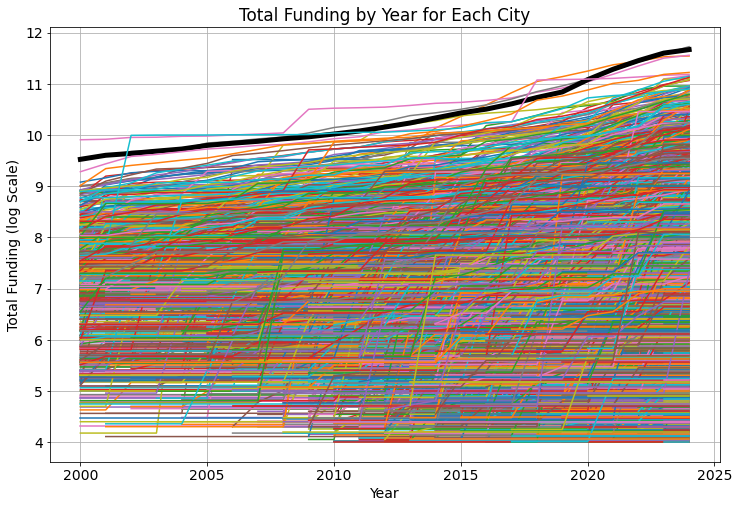

In [8]:
df = df_total_funding[df_total_funding.total_funding>10000]
# Plotting
plt.figure(figsize=(12, 8))

# Loop through each city and plot its data
for city in df['city'].unique():
    city_data = df[df['city'] == city]
    if city !='San Francisco':
        plt.plot(city_data['year'], 
             np.log10(city_data['total_funding']), 
             label=city)
    else:
        plt.plot(city_data['year'], 
             np.log10(city_data['total_funding']),
             lw=5,
             color='k',
             label=city)

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Total Funding (log Scale)')
plt.title('Total Funding by Year for Each City')
# plt.legend()
plt.grid(True)


In [26]:
df_total_funding.to_csv('total_funding.csv',index=False)

In [9]:
edgelist_df = extractBipartiteEdgelist(df_org_foundation,
                                        df_jobs_cleaned,
                                        'founded_on',
                                        'started_on',
                                        year=2024)

In [24]:
df.to_csv('matrix_edgelist_result.csv',index=False)

In [46]:
setOfCities = set(filtered_df.city_1.tolist())

setOfCities = setOfCities.difference(set(df.city.unique()))

setOfCities.add('London')

results = Parallel(n_jobs=-1)(delayed(process_city_year)(city, year, filtered_df[(filtered_df.city_1 == city) & (filtered_df.year <= year)])
                              for city in setOfCities
                              for year in sorted(filtered_df[filtered_df.city_1 == city]['year'].unique()))

# Convert results to DataFrame or use as needed
networkResults = pd.DataFrame(results, columns=['number_of_components', 'n_nodes', 'n_edges', 'density', 'global_efficiency', 'diameter', 'shortest_path', 'city', 'year'])


In [48]:
df = pd.read_csv('matrix_edgelist_result.csv')